# Simulacion de ADC con filtrado
Al asumir que la variable del dataset es una señal continua y sabemos la frecuencia de recolección de datos se simula una señal analógica con su frecuencia correspondiente de muestreo (para este caso 50hz) y se aplica un filtrado sobre los datos para luego realizar el proceso tipico de un ADC.  
Usa los filtros de Kalman y Leunberger respectivamente para suavizar y evitar el ruido de la señal.

## Definicion de funciones
Funcion:

In [92]:
# Para el manejo de arrays
import numpy as np

# Función para decimación simple (entero)
def downsample(signal, fs_in, fs_out):
    """
    Reduce la frecuencia de muestreo de fs_in a fs_out por decimación simple.
    Retorna la señal decimada y la nueva fs (fs_out).
    """
    if fs_out >= fs_in:
        raise ValueError("fs_out debe ser menor que fs_in para downsampling.")
    decim_factor = fs_in / fs_out
    if abs(decim_factor - round(decim_factor)) > 1e-9:
        raise ValueError("Solo se permite decimación entera en este modo simplificado.")
    M = int(round(decim_factor))
    y = signal[::M]
    return y, fs_out

# Función de cuantización
def quantize(signal, bits=None, levels=None, v_min=None, v_max=None, scheme='mid-rise'):
    if bits is None and levels is None:
        raise ValueError("Proporcionar bits o levels.")
    if bits is not None:
        L = 2 ** int(bits)
    else:
        L = int(levels)
    if v_min is None:
        v_min = float(np.min(signal))
    if v_max is None:
        v_max = float(np.max(signal))
    if v_min == v_max:
        v_max = v_min + 1e-6
    s_clipped = np.clip(signal, v_min, v_max)
    delta = (v_max - v_min) / L
    if scheme == 'mid-rise':
        indices = np.floor((s_clipped - v_min) / delta).astype(int)
        indices = np.clip(indices, 0, L-1)
        levels_values = v_min + (indices + 0.5) * delta
    elif scheme == 'mid-tread':
        indices = np.round((s_clipped - v_min) / delta - 0.5).astype(int)
        indices = np.clip(indices, 0, L-1)
        levels_values = v_min + (indices + 0.5) * delta
    else:
        raise ValueError("scheme debe ser 'mid-rise' o 'mid-tread'")
    signal_q = levels_values
    return signal_q, indices, levels_values

### Los filtros de Leunberger y Kalman

In [93]:
def luenberger_filter(signal, a=1.0, c=1.0, L=0.2):
    x_hat = np.zeros_like(signal)
    for k in range(1, len(signal)):
        x_hat[k] = a * x_hat[k-1] + L * (signal[k-1] - c * x_hat[k-1])
    return x_hat

def kalman_filter(signal, Q=1e-5, R=1e-2):
    n = len(signal)
    x_hat = np.zeros(n)
    P = np.zeros(n)
    x_hat[0] = signal[0]
    P[0] = 1.0
    for k in range(1, n):
        x_pred = x_hat[k-1]
        P_pred = P[k-1] + Q
        K = P_pred / (P_pred + R)
        x_hat[k] = x_pred + K * (signal[k] - x_pred)
        P[k] = (1 - K) * P_pred
    return x_hat

## Experimentos
En esta seccion del cuaderno se experimenta sobre los valores para los filtros y se puede modificar la frecuencia de muestreo y nivel de quantizacion deseado.

In [94]:
import matplotlib.pyplot as plt
import pandas as pd

# --- Cambia aquí el path y la columna que quieres usar ---
csv_path = "A_DeviceMotion_data/wlk_7/sub_1.csv"
columna = "userAcceleration.x"

# Leer el CSV
df = pd.read_csv(csv_path)
signal = df[columna].values
fs_high = 50.0  # Frecuencia de muestreo del dataset

# Parámetros ADC deseado
fs_out = 25.0   # 25 Hz
bits = 8
v_min = float(np.min(signal))
v_max = float(np.max(signal))

In [95]:
# Filtro Luenberger
signal_luenberger = luenberger_filter(signal, L=0.08) # Ajustar L segun la señal
signal_ds_luenberger, _ = downsample(signal_luenberger, fs_high, fs_out)
signal_q_luenberger, _, _ = quantize(signal_ds_luenberger, bits=bits, v_min=v_min, v_max=v_max, scheme='mid-rise')

# Filtro Kalman
signal_kalman = kalman_filter(signal, Q=1e-3, R=2e-2) # Ajustar Q y R segun la señal
signal_ds_kalman, _ = downsample(signal_kalman, fs_high, fs_out)
signal_q_kalman, _, _ = quantize(signal_ds_kalman, bits=bits, v_min=v_min, v_max=v_max, scheme='mid-rise')

# Tiempos para señal muestreada
t = np.arange(len(signal)) / fs_high
t_ds = np.arange(len(signal_ds_luenberger)) / fs_out

### Graficación para visualización

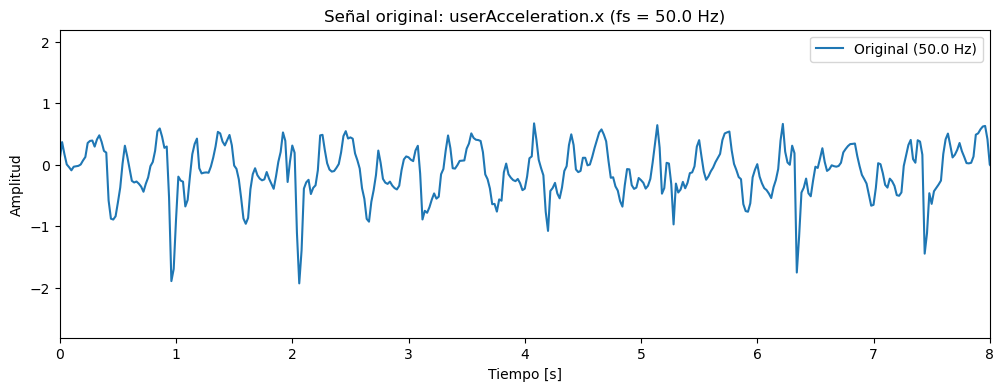

In [123]:
# Graficación de la señal original
plt.figure(figsize=(12,4))
plt.plot(t, signal, label='Original ({} Hz)'.format(fs_high)) # Señal original
plt.title('Señal original: {} (fs = {} Hz)'.format(columna, fs_high))
plt.ylabel('Amplitud')
plt.xlabel('Tiempo [s]')
plt.xlim(0, 8) # Limitar a 10 segundos para mejor visualización
plt.legend()

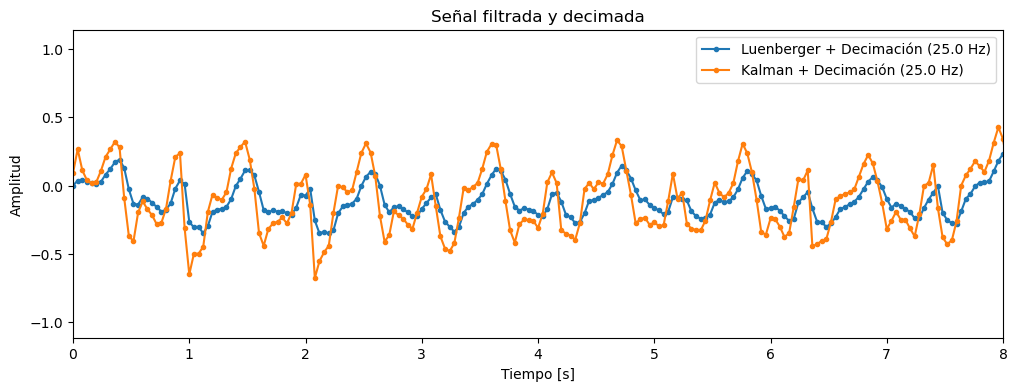

In [124]:
# Graficación de señales muestreadas (Luenberger y Kalman)
plt.figure(figsize=(12, 4))
plt.title('Señal filtrada y decimada')
plt.plot(t_ds, signal_ds_luenberger, '.-', label='Luenberger + Decimación ({} Hz)'.format(fs_out)) # Señal Luenberger decimada
plt.plot(t_ds, signal_ds_kalman, '.-', label='Kalman + Decimación ({} Hz)'.format(fs_out)) # Señal Kalman decimada
plt.ylabel('Amplitud')
plt.xlabel('Tiempo [s]')
plt.xlim(0, 8) # Limitar a 10 segundos para mejor visualización
plt.legend()

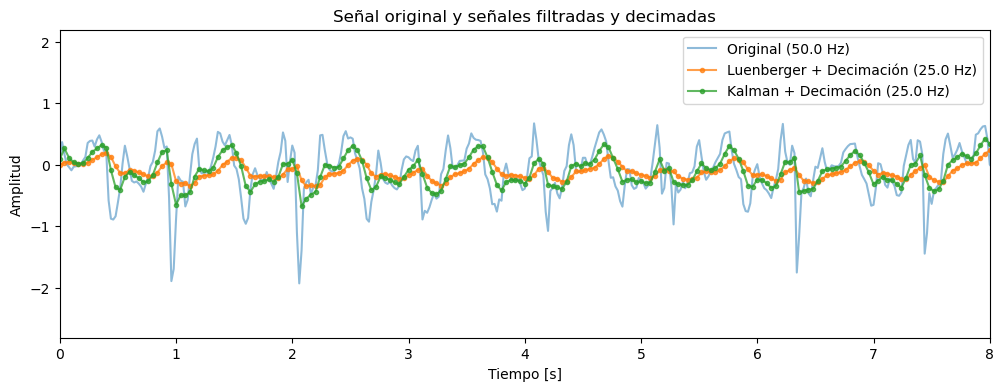

In [125]:
# Graficación de señales muestreadas y filtradas sobre original (Luenberger y Kalman)
plt.figure(figsize=(12, 4))
plt.title('Señal original y señales filtradas y decimadas')
plt.plot(t, signal, label='Original ({} Hz)'.format(fs_high), alpha=0.5) # Señal original
plt.plot(t_ds, signal_ds_luenberger, '.-', label='Luenberger + Decimación ({} Hz)'.format(fs_out), alpha=0.75) # Señal Luenberger decimada
plt.plot(t_ds, signal_ds_kalman, '.-', label='Kalman + Decimación ({} Hz)'.format(fs_out), alpha=0.75) # Señal Kalman decimada
plt.ylabel('Amplitud')
plt.xlabel('Tiempo [s]')
plt.xlim(0, 8) # Limitar a 8 segundos para mejor visualización
plt.legend()

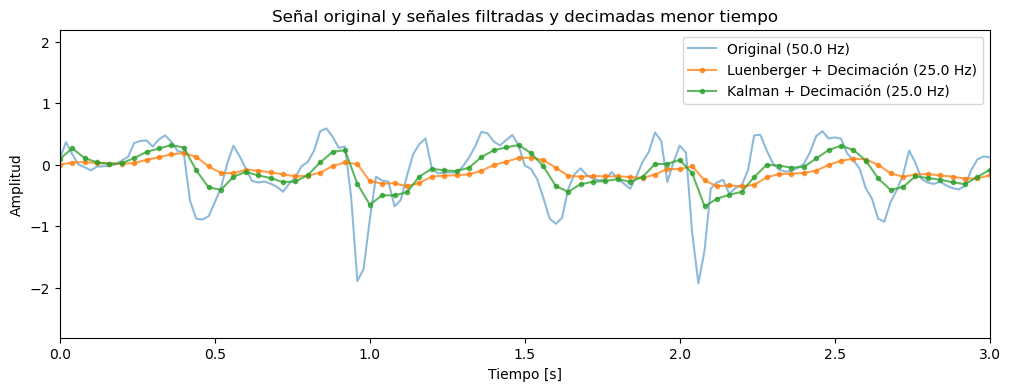

In [127]:
# Graficación de señales muestreadas y filtradas sobre original (Luenberger y Kalman)
plt.figure(figsize=(12,4))
plt.title('Señal original y señales filtradas y decimadas menor tiempo')
plt.plot(t, signal, label='Original ({} Hz)'.format(fs_high), alpha=0.5) # Señal original
plt.plot(t_ds, signal_ds_luenberger, '.-', label='Luenberger + Decimación ({} Hz)'.format(fs_out), alpha=0.75) # Señal Luenberger decimada
plt.plot(t_ds, signal_ds_kalman, '.-', label='Kalman + Decimación ({} Hz)'.format(fs_out), alpha=0.75) # Señal Kalman decimada
plt.ylabel('Amplitud')
plt.xlabel('Tiempo [s]')
plt.xlim(0, 3) # Limitar a 10 segundos para mejor visualización
plt.legend()

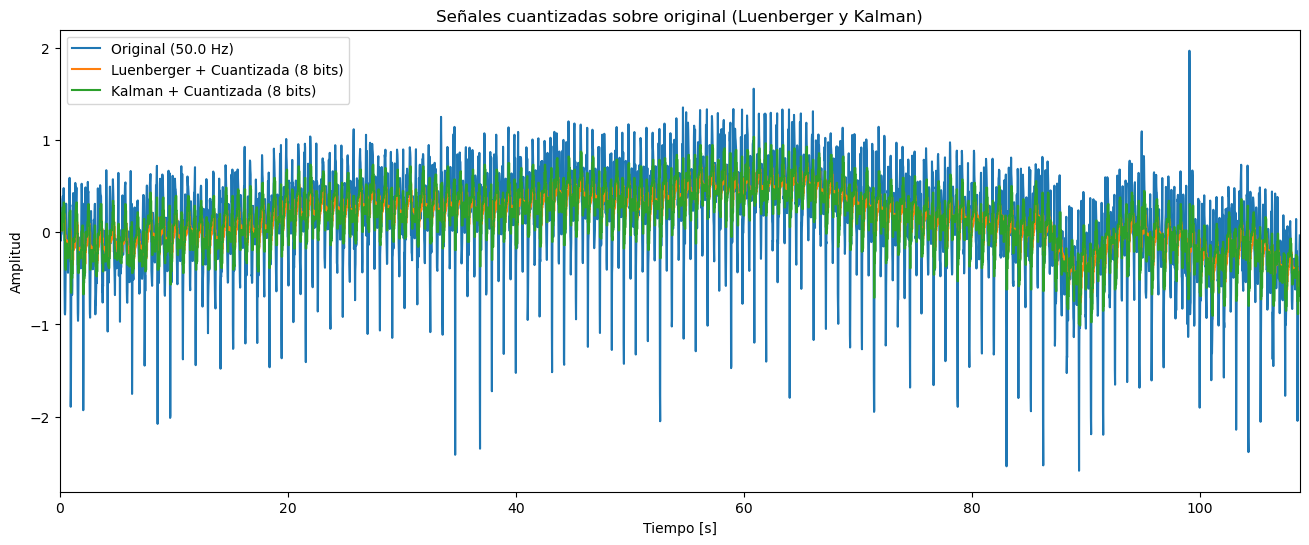

In [100]:
# Graficacion de señales cuantizadas sobre original (Luenberger y Kalman)
plt.figure(figsize=(16,6))
plt.title('Señales cuantizadas sobre original (Luenberger y Kalman)')
plt.plot(t, signal, label='Original ({} Hz)'.format(fs_high)) # Señal original
plt.step(t_ds, signal_q_luenberger, where='mid', label='Luenberger + Cuantizada ({} bits)'.format(bits)) # Señal Luenberger cuantizada
plt.step(t_ds, signal_q_kalman, where='mid', label='Kalman + Cuantizada ({} bits)'.format(bits)) # Señal Kalman cuantizada
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')
plt.xlim(0, t[-1]) # Limitar a 10 segundos para mejor visualización
plt.legend()
plt.show()

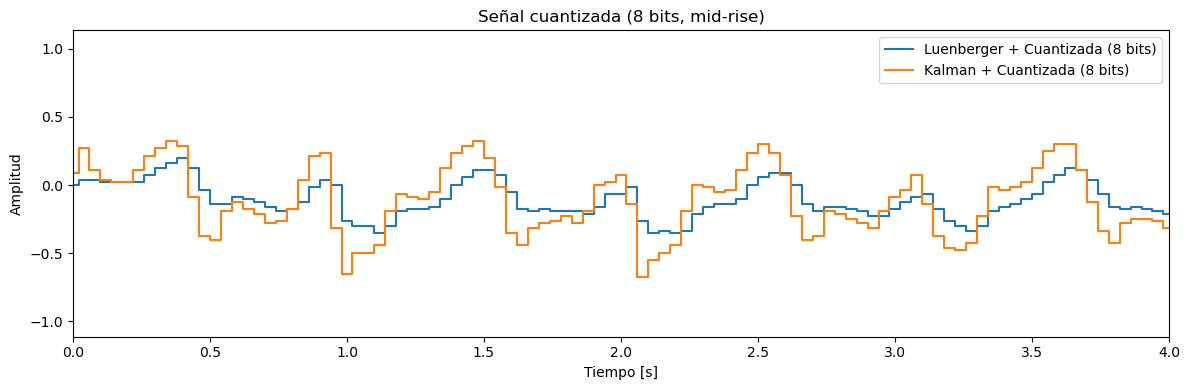

In [128]:
# Graficación de señales cuantizadas (Luenberger y Kalman)
plt.figure(figsize=(12,4))
plt.title('Señal cuantizada ({} bits, mid-rise)'.format(bits))
plt.step(t_ds, signal_q_luenberger, where='mid', label='Luenberger + Cuantizada ({} bits)'.format(bits)) # Señal Luenberger cuantizada
plt.step(t_ds, signal_q_kalman, where='mid', label='Kalman + Cuantizada ({} bits)'.format(bits)) # Señal Kalman cuantizada
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')
plt.xlim(0, 4) # Limitar a 8 segundos para mejor visualización
plt.legend()
plt.tight_layout()
plt.show()

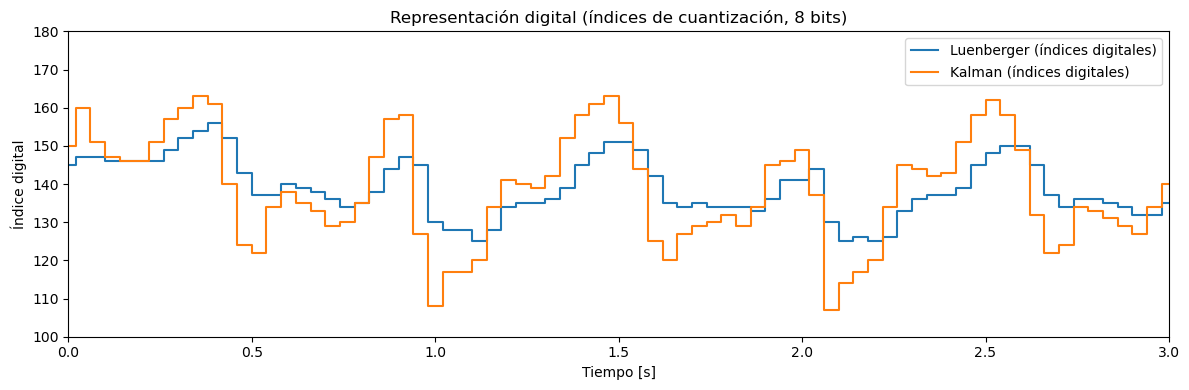

Primeros 10 valores digitales (Luenberger) en binario:
['10010001', '10010011', '10010011', '10010010', '10010010', '10010010', '10010010', '10010101', '10011000', '10011010']


In [132]:
BITS = 8        # Bits de cuantización

# --- Representación digital: índices de cuantización ---
_, indices_luenberger, _ = quantize(signal_ds_luenberger, bits=BITS, v_min=v_min, v_max=v_max)
_, indices_kalman, _ = quantize(signal_ds_kalman, bits=BITS, v_min=v_min, v_max=v_max)

plt.figure(figsize=(12,4))
plt.step(t_ds, indices_luenberger, where='mid', label=f'Luenberger (índices digitales)')
plt.step(t_ds, indices_kalman, where='mid', label=f'Kalman (índices digitales)')
plt.title(f'Representación digital (índices de cuantización, {BITS} bits)')
plt.xlabel('Tiempo [s]')
plt.ylabel('Índice digital')
plt.xlim(0, 3)
plt.ylim(100, 180)
plt.legend()
plt.tight_layout()
plt.show()

# --- Ejemplo: mostrar los primeros 10 valores en binario ---
indices_binarios = [format(idx, f'0{BITS}b') for idx in indices_luenberger[:10]]
print("Primeros 10 valores digitales (Luenberger) en binario:")
print(indices_binarios)

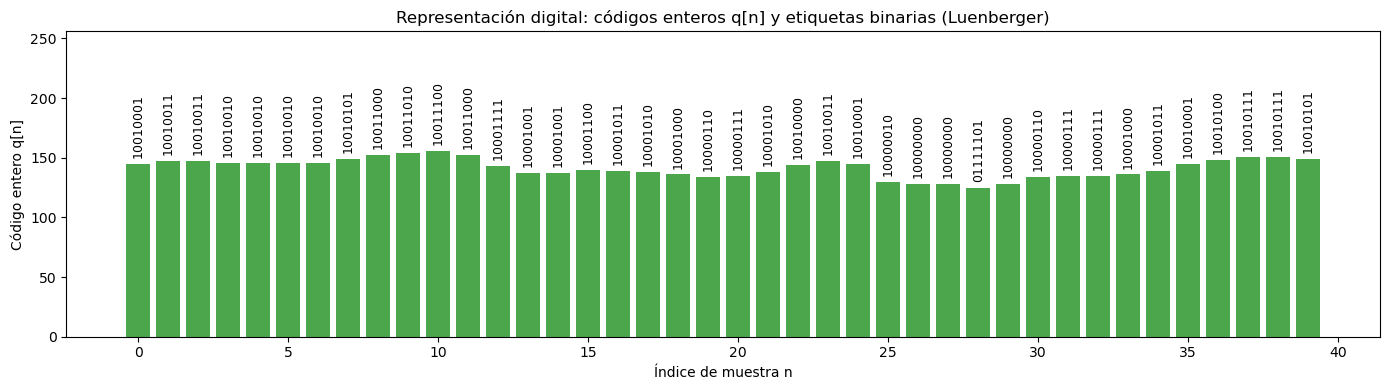

In [ ]:
# Graficar índices digitales y mostrar binarios para Leunberger como barras
plt.figure(figsize=(14, 4))
n_muestras = 40  # Número de muestras a mostrar (ajusta según lo que quieras ver)
x = np.arange(n_muestras)
y = indices_luenberger[:n_muestras]
plt.bar(x, y, color='green', alpha=0.7)

# Etiquetas binarias encima de cada barra
for i in range(n_muestras):
    plt.text(x[i], y[i]+5, format(y[i], f'0{BITS}b'), ha='center', va='bottom', fontsize=9, rotation=90, color='black')

plt.title('Representación digital: códigos enteros q[n] y etiquetas binarias (Luenberger)')
plt.xlabel('Índice de muestra n')
plt.ylabel('Código entero q[n]')
plt.ylim(0, 2**BITS)
plt.tight_layout()
plt.show()

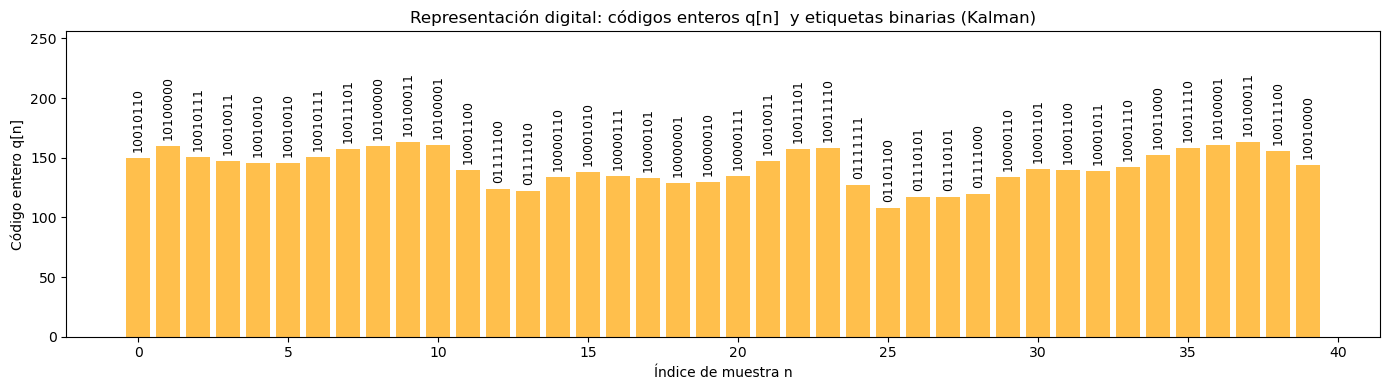

In [120]:
# Graficar índices digitales y mostrar binarios para Kalman como barras
plt.figure(figsize=(14, 4))
n_muestras = 40  # Número de muestras a mostrar (ajusta según lo que quieras ver)
x = np.arange(n_muestras)
y = indices_kalman[:n_muestras]
plt.bar(x, y, color='orange', alpha=0.7)

# Etiquetas binarias encima de cada barra
for i in range(n_muestras):
    plt.text(x[i], y[i]+5, format(y[i], f'0{BITS}b'), ha='center', va='bottom', fontsize=9, rotation=90, color='black')

plt.title('Representación digital: códigos enteros q[n]  y etiquetas binarias (Kalman)')
plt.xlabel('Índice de muestra n')
plt.ylabel('Código entero q[n]')
plt.ylim(0, 2**BITS)
plt.tight_layout()
plt.show()